# Computing evaluation metrics for detection

We will use the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip) here. To download it, paste the following code inside a cell (including the exclamation marks) and execute the cell.

```
!wget -q https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q PennFudanPed.zip && mv PennFudanPed data && rm PennFudanPed.zip
```

The dataset contains 170 images with 345 instances of pedestrians. To run the notebook, download the dataset, unzip it and move it into the `data/` directory.

In [ ]:
from lib.penn_fundan import PennFudanDataset
from lib.detection.transforms import ToTensor

dataset = PennFudanDataset('data/PennFudanPed/', ToTensor())

## TP, FP, FN at an IoU level

We have already learned about [evaluation metrics for classification](../2_classification/2_evaluation_metrics.ipynb). In object detection, we also perform some kind of classification. More specifically, a detector returns a set of bounding boxes with corresponding class labels. As such, the model has classified the image regions that correspond to the bounding boxes.

To evaluate the predictions, we compare them with the **ground-truth bounding boxes**. However, **predictions will almost never exactly overlap** with a ground-truth bounding box. Of course, this does not mean that all predicted bounding boxes are *bad* and should be counted as false positives. Instead, we use the **Intersection over Union** (IoU) to define when a predicted bounding box is a TP, FP or FN for a certain class.

We can choose this IoU ourselves. Let's say we give it a value $\alpha$. Then a TP, FP and FN of a class label *A* at this IoU level $\alpha$ is defined as follows:

- **True positive at $\alpha$** ($\text{TP}_\alpha$) of label *A*: the predicted bounding box has label *A* and has an IoU $\ge \alpha$ with a ground truth bounding box that has label *A*
- **False positive at $\alpha$** ($\text{FP}_\alpha$) of label *A*: the predicted bounding box has label *A*, but does not have an IoU $\ge \alpha$ with a ground truth bounding box that has label *A*
- **False negative at $\alpha$** ($\text{FN}_\alpha$) of label *A*: a ground truth bounding box that has label *A*, without there being any prediction of label *A* that has an IoU $\ge \alpha$ with it

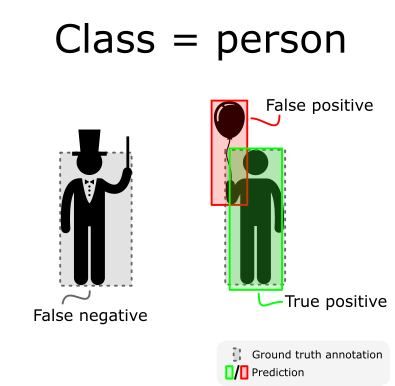

Defining *True negatives at $\alpha$* is not necessary, since we do not use it to calculate precision and recall. This makes sense, because the amount of regions in an image that *do not* belong to a certain class is huge and rather uninformative.

## Precision and Recall at an IoU level

Now that we have defined how we to calculate $\text{TP}_\alpha$, $\text{FP}_\alpha$ and $\text{FN}_\alpha$ for a certain class label at a give IoU level $\alpha$, we can calculate the precision and recall at that IoU level:

$$\text{Precision}_\alpha = \frac{\text{TP}_\alpha}{\text{TP}_\alpha + \text{FP}_\alpha}$$

$$\text{Recall}_\alpha = \frac{\text{TP}_\alpha}{\text{TP}_\alpha + \text{FN}_\alpha}$$

## Interactive widget: TP/FP/FN and Precision/Recall at IoU level

With the cell below, you can get a better idea of what the concepts $\text{TP}_\alpha$, $\text{FP}_\alpha$ and $\text{FN}_\alpha$ mean. We select the image at index `img_idx` from the Penn-Fudan dataset and draw the **ground truth annotations with a dashed stroke**. Then, in a **solid stroke, we draw the predictions**. Note that these predictions don't *actually* come from a real detector, but rather are created by randomly modifying the ground truth boxes.

- `box_sigma`: The more you increase `box_sigma`, the greater the random distortion.
- `prob_droupout`: The probability to drop a ground truth box as prediction.
- `iou_thresh`: The IoU threshold (i.e., $\alpha$)
- `pos_label`: The class to evaluate. For Penn-Fudan, there's only one class, i.e., *Person*.
- `seed`: The random seed to use in the pseudo-random generator.

After setting the parameters, the widget will print the amount of true positives (TP), false positives (FP) and false negatives at the chosen IoU threshold. From these, it computes the precision and recall.

In [ ]:
from lib.widgets import interact_pseudo_detection

interact_pseudo_detection(dataset)

## Average Precision at an IoU level

The detector will return a score that indicates how convinced it is of its prediction. As with classification, we can threshold this score to improve our precision. Then, every predicted bounding box that has a confidence score lower than the threshold is dropped. When we plot the precision and recall for all possible threshold values, we obtain a PR-curve for the chosen IoU level.

To summarize the PR-curve at the chosen IoU level, we can again compute the **average precision**, which is the integral of the PR-curve.

$$
\text{AP}_\alpha = \sum_{t} P_\alpha(t)\cdot (R_{\alpha}(t) - R_\alpha(t-1))
$$

with $P_\alpha(t)$ and $R_\alpha(t)$ the precision, resp. recall, at threshold $t$ and IoU level $\alpha$ ($R_\alpha(0)$ is defined as 1).

The **mean Average Precision at $\alpha$** ($\text{mAP}_\alpha$) is the mean of the $\text{AP}_\alpha$ of each class in the dataset.

$$
\text{mAP}_\alpha = \frac{1}{C} \sum_{i=1}^{C} \text{AP}_{\alpha,i}
$$

With $C$ the number of classes and $\text{AP}_{\alpha,i}$ the average precision for class $i$ at IoU $\alpha$.

## COCO AP

It is common to simply use $\alpha=0.5$ when computing $\text{mAP}_\alpha$ for a detector. However, we can also calculate $\text{mAP}_\alpha$ for multiple values of $\alpha$. In the literature, **COCO AP** is frequently used as a metric. It is computed as the average of $\text{mAP}_{0.50}$, $\text{mAP}_{0.55}$, $\text{mAP}_{0.60}$, ..., $\text{mAP}_{0.95}$. It is written as $\text{mAP}_{[.5:.05:.95]}$ or $\text{AP}_{\text{COCO}}$ or even just $\text{AP}$.

When reporting COCO AP, it is recommended to use the official `pycocotools` to guarantee a fair comparison with other published work. The `pycocotools` API itself is rather cumbersome, however, so we will use a wrapper around it. This wrapper comes from torchvision reference scripts that we have copied from [here](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) and put into `lib.detection`.

## Converting a `Dataset` into a `COCO` instance

To compute the COCO metrics, we first need to create a `pycocotools.coco.COCO` instance. This is an object that represents the entire dataset with ground truth annotations. With our wrapper, we can easily convert a PyTorch `Dataset` into such a `pycocotools.coco.COCO` instance. For this to work, the dataset `__getitem__` should return a tuple `(image, target)`, with

* `image`: a torch Tensor of shape `(C, H, W)`
* `target`: a dictionary containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.

Luckily, our `PennFudanDataset` fits this protocol.

In [ ]:
from lib.detection.coco_utils import get_coco_api_from_dataset

coco = get_coco_api_from_dataset(dataset)

## Creating an evaluator

The `pycocotools.coco.COCO` represents the ground-truth data. It will be used by `pycocotools.cocoeval.COCOeval` to compute the COCO AP (among others). Again, we will use a torchvision reference script to hide the `pycocotools` API and make it a bit easier to use.

In [ ]:
from lib.detection.coco_eval import CocoEvaluator

coco_evaluator = CocoEvaluator(coco, ["bbox"])

Once our evaluator is set up, it is only a matter of passing our predictions to it and computing the COCO metrics!

This happens in two stages, however. First, we **update** the evaluator with each image for which we have calculated a prediction. Next, we **accumulate** the results of the images.

## Updating the evaluator

This is done with a result `dict` that contains the corresponding `image_id`s as dictionary keys. The dictionary value of each of these keys is also a dictionary with the following fields:

* `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` predicted bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
* `labels` (`Int64Tensor[N]`): the predicted label for each bounding box
* `scores` (`Tensor[N]`): The confidence score for each bounding box.

You can call `update()` multiple times, each time with a different set of images. As long as you do not call `accumulate()`, the results will simply be *appended* (unless if you call `update()` with the same image id again, then the previous result for that image will be overwritten by the new one).

In [ ]:
img_idx = 5
img, target = dataset[img_idx]
target

Let's create a fake detection for the image sampled above, and update the `CocoEvaluator`.

In [ ]:
import torch

sigma = 10

# Randomly offset ground truth boxes to create pseudo detections
pseudo_boxes = target['boxes'] + sigma * torch.randn_like(target['boxes'])

# Set all confidence levels to 1
pseudo_scores = torch.ones(len(target['boxes']))

pseudo_res = {
    img_idx: {
        'boxes': pseudo_boxes,
        'scores': pseudo_scores,
        'labels': target['labels'],
    }
}

coco_evaluator.update(pseudo_res)

## Accumulate the evaluator

Once we have updated the evaluator with each image for which we have a prediction, we call `accumulate()` to accumulate the evaluations of these predictions.

In [ ]:
coco_evaluator.accumulate()

## Print the results

To show the results, we can call `summarize()`.

In [ ]:
coco_evaluator.summarize()